In [11]:
import torch 
import torchdiffeq
import torch.nn as nn
import math
import numpy as np
#from torchdiffeq import odeint as odeint

In [12]:
#phi(a, gamma_a) = a ./ (a + gamma_a)

class model(nn.Module):
    def __init__(self, params, device):
        super().__init__()
        self.params = nn.Parameter(params)
        
    def phi(self, u, γu):
        return u / (u+γu)
        
    def forward(self, t, u):
        βa, βB, βE1, βE2, βh1, βh2, βh3, βM1, βM2, βp, γa, γB, γh, γp, μaE, μaM, μhM, μpB, μpE, q = self.params
        B, E, M, a, h, p = u
        
        
        nextB = βB*self.phi(p,γp)*B - q*B
        nextE = (βE1*self.phi(a, γa) + βE2*(1-self.phi(B, γB))*self.phi(p, γp))*E - q*E
        nextM = (βM1*self.phi(a, γa) + βM2*self.phi(h, γh))*M - q*M

        nexta = βa*self.phi(p, γp)*B - q*a - (μaE*E + μaM*M)*self.phi(a, γa)
        nexth = βh1*self.phi(a, γa)*E + βh2*self.phi(p, γp)*B - q*h- μhM*self.phi(h, γh)*M + βh3*(1-self.phi(B, γB))*self.phi(p, γp)*E 
            
        nextp = βp*q*(math.cos(t)+1)**3 - q*p - (μpB*B + μpE*E)*self.phi(p, γp)
        
        return torch.stack([nextB,nextE, nextM, nexta, nexth, nextp])

In [296]:
#phi(a, gamma_a) = a ./ (a + gamma_a)

class old_model(nn.Module):
    def __init__(self, params, device):
        super().__init__()
        self.params = nn.Parameter(params)
        
    def phi(self, u, γu):
        return u / (u+γu)
        
    def forward(self, t, u):
        βa, βB, βE1, βE2, βh1, βh2, βh3, βM1, βM2, βp, γa, γB, γh, γp, μaE, μaM, μhM, μpB, μpE, q = self.params
        B, E, M, a, h, p = u
        
        
        nextB = βB*self.phi(p,γp)*B - q*B
        nextE = (βE1*self.phi(a, γa) + βE2*(1-self.phi(B, γB))*self.phi(p, γp))*E - q*E
        nextM = (βM1*self.phi(a, γa) + βM2*self.phi(h, γh))*M - q*M

        nexta = βa*self.phi(p, γp)*B - q*a - (μaE*E + μaM*M)*self.phi(a, γa)
        nexth = βh1*self.phi(a, γa)*E + βh2*self.phi(p, γp)*B + βh3*(1-self.phi(B, γB))*self.phi(p, γp)*E - q*h- μhM*M*self.phi(h, γh)  
            
        nextp = βp*q*(math.cos(t)+1)**3 - q*p - μpB*B*self.phi(p, γp) - μpE*E*self.phi(p, γp)
        
        return torch.stack([nextB,nextE, nextM, nexta, nexth, nextp])

In [369]:
u0 = torch.tensor([0.0004706, 0.0004706, 0.0004706, 9.7079, 7.9551, 32.061])
tspan = (0.0,500.0);
p = torch.nn.Parameter(torch.tensor([3e5, # betaa 1e7
    1.2, # betab
    0.8, # betaE1
    0.6, # betaE2
    150, #betah1 150
    33000, #betah2
    10000,  #betah3                   
    1.0, #betaM1 0.8
    0.5, #betaM2
    1000, #betap 10000
    200, #gammaa
    10, # gammaB
    150, #gammah
    400, # gammap 400
    50000, # muaE 25000
    40000, # muaM 50000
    5000, # muhM 400
    200000, #mupB
    5000000, #mupE
    0.05]),requires_grad = False) #0.1 # q

In [370]:
device = 'cpu'
diffeq = old_model(p, device)

In [371]:
from torchdiffeq import odeint_adjoint
from torchdiffeq import odeint
import matplotlib.pyplot as plt
adjoint = True
ode_integrator = odeint_adjoint if adjoint else odeint

In [372]:
n_points = 2000
tmax = 400
X = ode_integrator(diffeq, u0, torch.linspace(0, tmax, n_points, device=device))

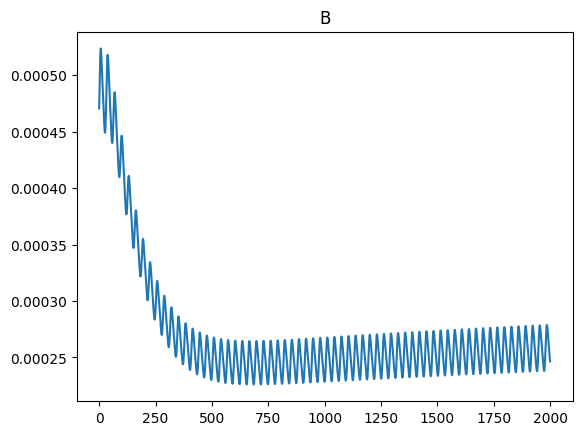

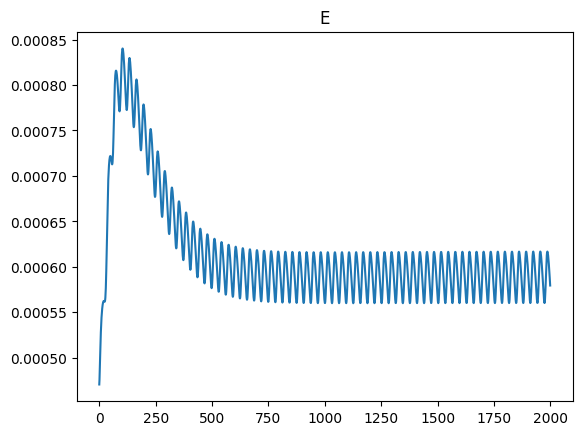

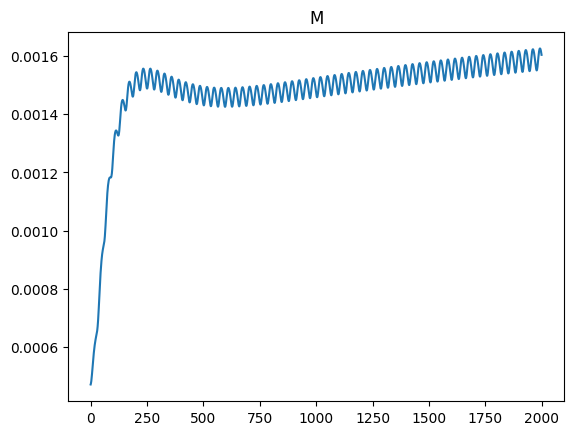

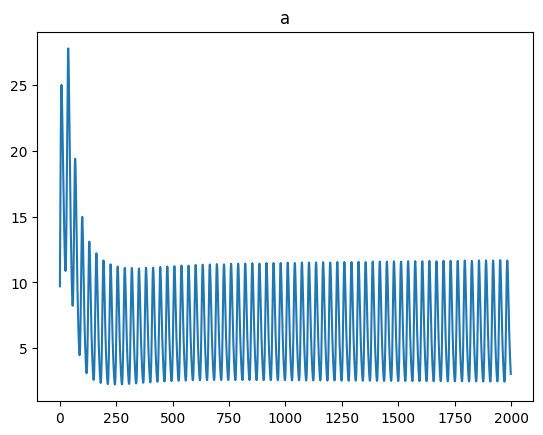

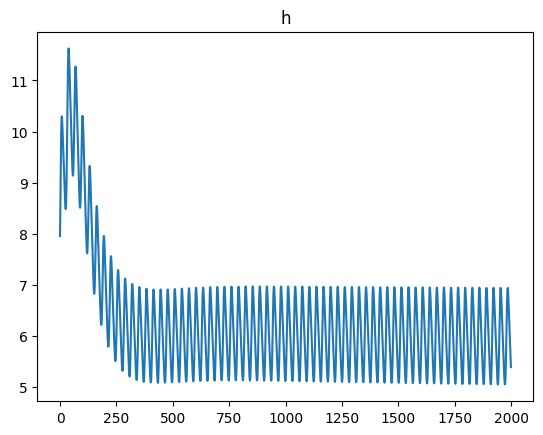

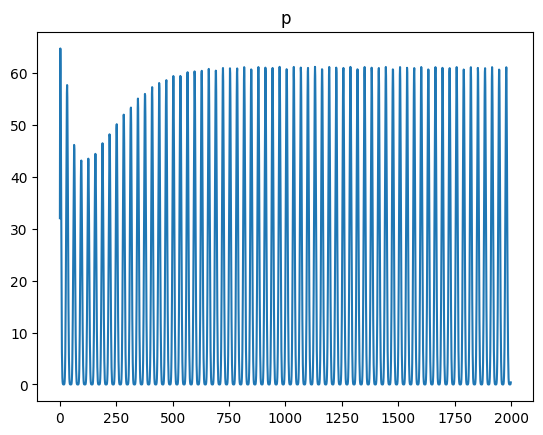

In [373]:
order = ["B", "E", "M", "a", "h", "p"]
for i in range(6):
    #plt.plot(np.arange(0,300, 3/5), X[:,i].detach())
    plt.plot(range(n_points), X[:,i].detach())
    plt.title("{}".format(order[i]))
    plt.show()

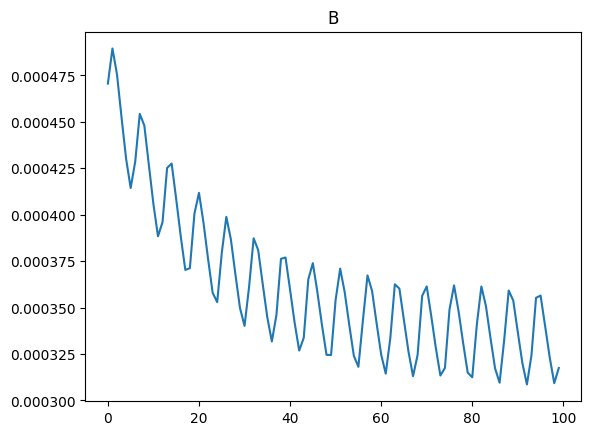

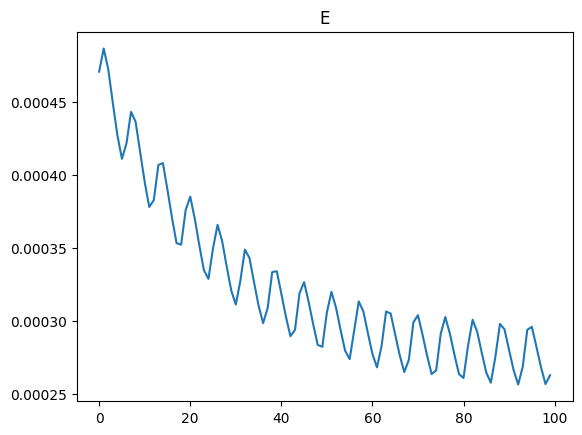

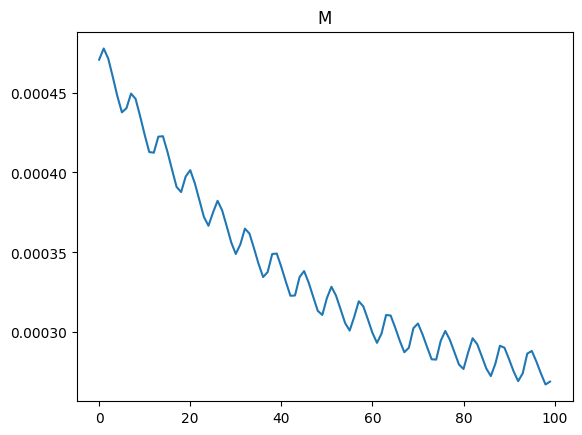

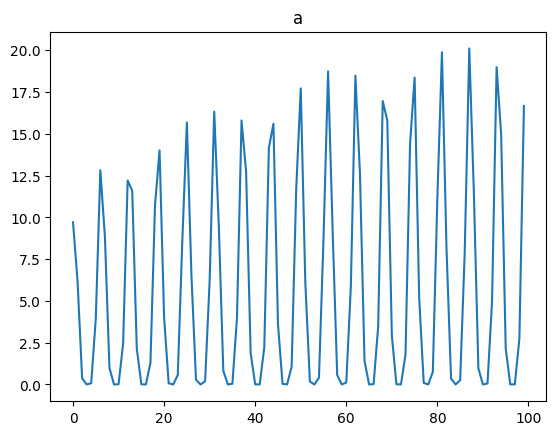

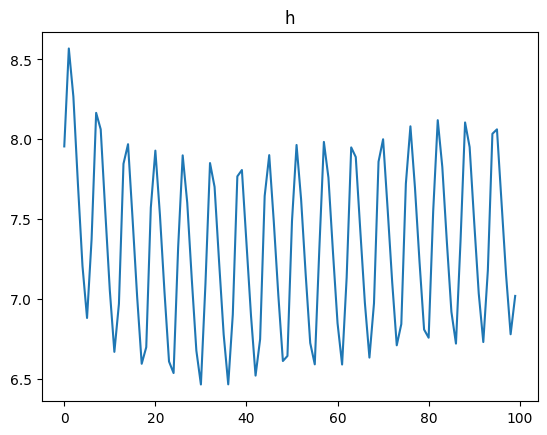

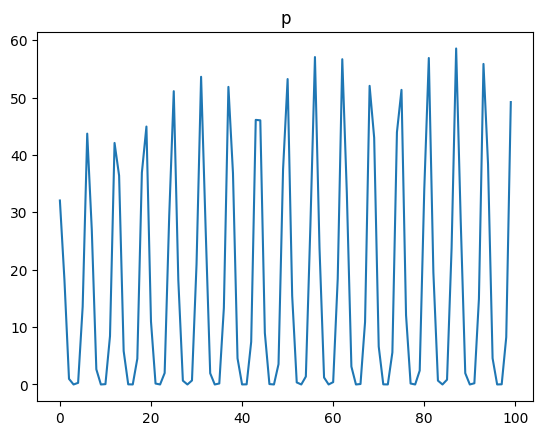

In [81]:
order = ["B", "E", "M", "a", "h", "p"]
for i in range(6):
    #plt.plot(np.arange(0,300, 3/5), X[:,i].detach())
    plt.plot(range(n_points), orig_solution[:,i].detach())
    plt.title("{}".format(order[i]))
    plt.show()

In [ ]:
# truth = u0; t_start = 400; t_end = 500; weight = u0
def loss(sol, truth, t_start, t_end, weight):
    """ loss computes a weighted mean squared error loss between a prediction (averaged across timepoints t_start to t_end) and ground truth weighted by a weight vector
    truth (Vector): vector containing the ground truth
    pred (Matrix): matrix with shape (variables, timepoints)
    t_start (integer): first timepoint to pull to compute an average across time
    t_end (integer): last timepoint to pull to compute an average across time
    """
    #print((truth-torch.mean(sol[t_start:t_end,:], dim=0))**2 /weight)
    #return sum((truth-torch.mean(sol[t_start:t_end,:], dim=0))**2 /weight )#(u0-mean(sol[:,t_start:t_end], dims=2))./ weight
    s = (sum(truth[:3]) - sum(torch.mean(sol[t_start:t_end,:3], dim =0)) )**2 / sum(weight[:3])
    return s + sum((truth[3:]-torch.mean(sol[t_start:t_end,3:], dim=0))**2 /weight[3:] ) #+ torch.var(sol[t_start:t_end,5])/weight[5]#(u0-mean(sol[:,t_start:t_end], dims=2))./ weight


In [ ]:
n_epochs = 1000

optimizer = torch.optim.Adam([{'params':diffeq.parameters(), 'lr':1e-2}])
lambda1 = lambda epoch: (epoch-9)**(-1) if epoch >=100 else 1
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

training_loss = []

for epoch in range(n_epochs):
    
    print("epoch", epoch)
    # zero out gradient information
    optimizer.zero_grad()
    
    # get ODE solution for timepoints 0 to 500, 1000 discrete points
    X = ode_integrator(diffeq, u0, torch.linspace(0, 300, 500, device=device))
    
    # compute the loss 
    l = loss(X,u0,300,500, u0)
    print(l)
    
    # store loss information, do not track gradient information for this operation
    with torch.no_grad():
        training_loss.append(l.detach().cpu())
    
    # compute gradient information
    l.backward()
    
    # update parameters based on gradient information
    optimizer.step()
    
    # update scheduler
    scheduler.step()


In [ ]:
#dir(diffeq)
#torch.save(diffeq.params,"params.pt")

In [ ]:
plt.plot(range(7), training_loss)

In [ ]:
X = ode_integrator(diffeq, u0, torch.linspace(0, 300, 500, device=device))

In [ ]:
for i in range(6):
    plt.plot(range(500), X[:,i].detach())
    plt.show()